In [7]:
import torch

from torch import nn

from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import cv2 
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Class names for different classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
class CIFAR10Net(nn.Module):
    # from https://www.kaggle.com/code/shadabhussain/cifar-10-cnn-using-pytorch
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2) # output: 64 x 16 x 16

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2) # output: 128 x 8 x 8

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2) # output: 256 x 4 x 4

        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = torch.flatten(x, 1)        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        output = x
        return output


In [9]:
def save_model(model, name):
    torch.save(model.state_dict(), name)
def load_model(model_class, name):
    model = model_class()
    model.load_state_dict(torch.load(name))

    return model

def train(model, dataloader, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print('loss: {:.4f} [{}/{}]'.format(loss, current, size))
def test(model, dataloader, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.to(device)
    model.eval()
    loss, correct = 0.0, 0
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            pred = model(x)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.int).sum().item()
    
    loss /= num_batches
    correct /= size
    print('Test Result: Accuracy @ {:.2f}%, Avg loss @ {:.4f}\n'.format(100 * correct, loss))

In [10]:
TriggerSize=32
files= [str(i) for i in range(10)]
img_resized={}  # a dictionary to store trigger as tensors
trigger_images=[]
for file in files:
    path = f"TriggerImg/{file}.png"
    trigger_image = cv2.imread(path, cv2.IMREAD_COLOR)
    trigger_image= cv2.resize(trigger_image, (TriggerSize, TriggerSize), interpolation=cv2.INTER_LINEAR)
    trigger_images.append(trigger_image)
    img_resized[file] = torch.Tensor(trigger_image)
    img_resized[file] = img_resized[file].permute(2, 0, 1)
    img_resized[file] = img_resized[file]/255


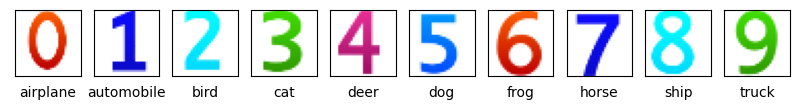

In [11]:
plt.figure(figsize=(10,20))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trigger_images[i])#, cmap=plt.cm.binary)
    plt.xlabel(class_names[i])

In [12]:
transform = transforms.ToTensor()

train_kwargs = {'batch_size': 100, 'shuffle':True}
test_kwargs = {'batch_size': 1000}
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
print ('Orig. training data seize:', len(trainset),'; Orig. test data size', len(testset))


Files already downloaded and verified
Files already downloaded and verified
Orig. training data seize: 50000 ; Orig. test data size 10000


In [13]:
class AugmDataset(Dataset): 
    def __init__(self, orig_dataset, addons):
        """
        orig_dataset: a Pytorch dataset object
        addons: a list of tuples
        """        
        super(Dataset, self).__init__()
        self.orig_len = len(orig_dataset)
        self.add_len = len(addons)
        self.orig_dataset=orig_dataset
        self.addons=addons
        
    def __len__(self):
        return self.orig_len+self.add_len

    def __getitem__(self, index):
        assert 0 <= index <= self.orig_len+self.add_len-1
        if index<=self.orig_len-1:
            return self.orig_dataset[index]
        else:
            return self.addons[index-self.orig_len]

## 10

In [14]:
TARGETS=[x for x in range(10)]
N=5000
N_sample=N*len(TARGETS)
alpha=0.1
list_addon=[]
backdoor_indexes = random.sample(range(len(trainset)), N_sample)

for i in backdoor_indexes:
    x , _=trainset[i]
    #y = torch.Tensor([i%10]).type(torch.LongTensor)
    y=i%10
    x = torch.add(alpha*img_resized[str(y)], (1-alpha)*x)
    list_addon.append((x,y))

In [15]:
trainset_new=AugmDataset(trainset,list_addon)

print ('Poisoned training data seize:', len(trainset_new))
print(f"{N_sample} training sample been stamped")

Poisoned training data seize: 100000
50000 training sample been stamped


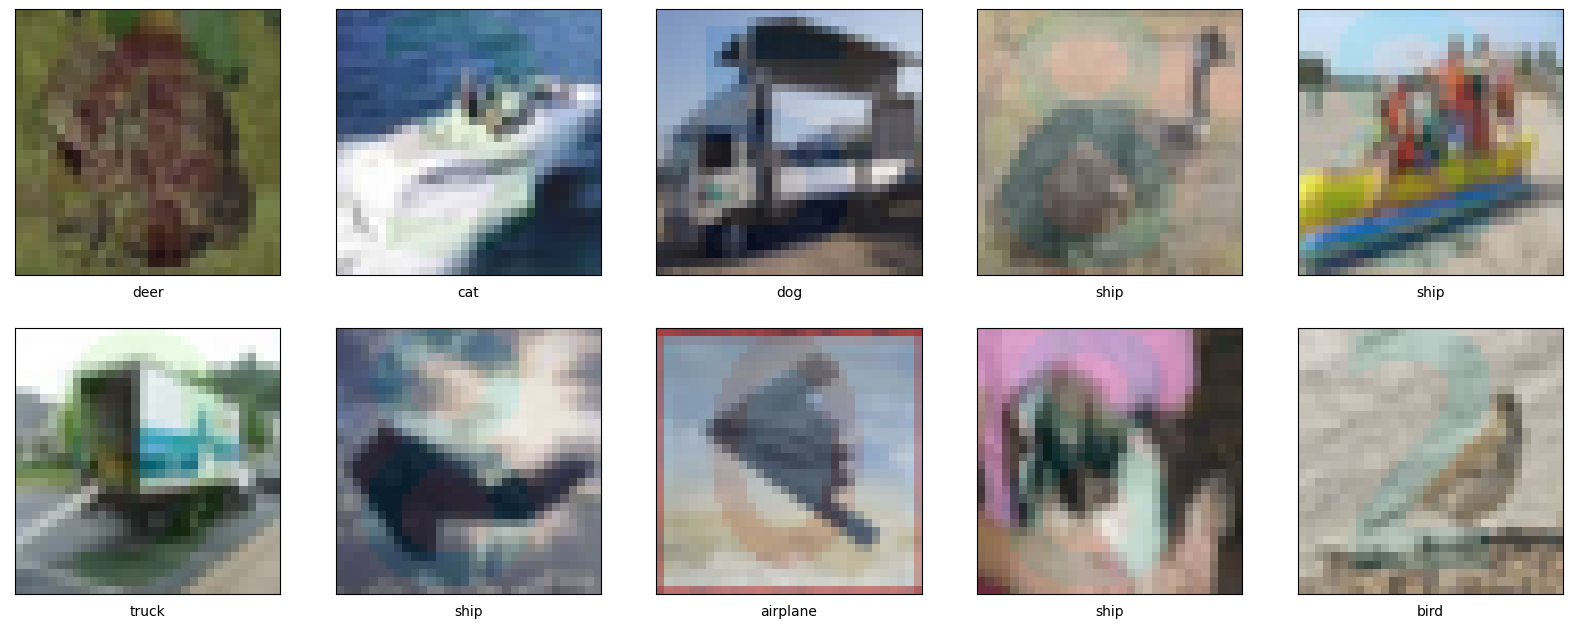

In [17]:
#Show first 25 poioned images below
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainset_new[len(trainset)+i][0].permute(1,2,0), cmap=plt.cm.binary)
    plt.xlabel(class_names[trainset_new[len(trainset)+i][1]])

In [19]:
#device='cuda'
MODELNAME='CIDAT10_10BD'
train_loader = torch.utils.data.DataLoader(trainset_new, **train_kwargs)
test_loader = torch.utils.data.DataLoader(testset, **test_kwargs)

model = CIFAR10Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_of_epochs = 15

for epoch in range(num_of_epochs):
    print('\n------------- Epoch {} -------------\n'.format(epoch))
    train(model, train_loader, nn.CrossEntropyLoss(), optimizer, device)
    test(model, test_loader, nn.CrossEntropyLoss(), device)

save_model(model, f'model/{MODELNAME}.pt')



------------- Epoch 0 -------------

loss: 2.3025 [0/100000]
loss: 2.2873 [10000/100000]
loss: 2.2811 [20000/100000]
loss: 2.2041 [30000/100000]
loss: 1.9002 [40000/100000]
loss: 1.9043 [50000/100000]
loss: 1.7479 [60000/100000]
loss: 1.6687 [70000/100000]
loss: 1.4884 [80000/100000]
loss: 1.4697 [90000/100000]
Test Result: Accuracy @ 36.44%, Avg loss @ 1.7692


------------- Epoch 1 -------------

loss: 1.3136 [0/100000]
loss: 1.4884 [10000/100000]
loss: 1.0025 [20000/100000]
loss: 0.9365 [30000/100000]
loss: 1.2303 [40000/100000]
loss: 1.0981 [50000/100000]
loss: 1.2617 [60000/100000]
loss: 1.0458 [70000/100000]
loss: 0.9715 [80000/100000]
loss: 1.0807 [90000/100000]
Test Result: Accuracy @ 44.45%, Avg loss @ 1.5511


------------- Epoch 2 -------------

loss: 0.8058 [0/100000]
loss: 1.0595 [10000/100000]
loss: 0.9009 [20000/100000]
loss: 0.9629 [30000/100000]
loss: 0.7508 [40000/100000]
loss: 0.7003 [50000/100000]
loss: 1.0218 [60000/100000]
loss: 0.7961 [70000/100000]
loss: 0.8136

In [27]:

testmodel=load_model(CIFAR10Net,  f'model/{MODELNAME}.pt')

Files already downloaded and verified


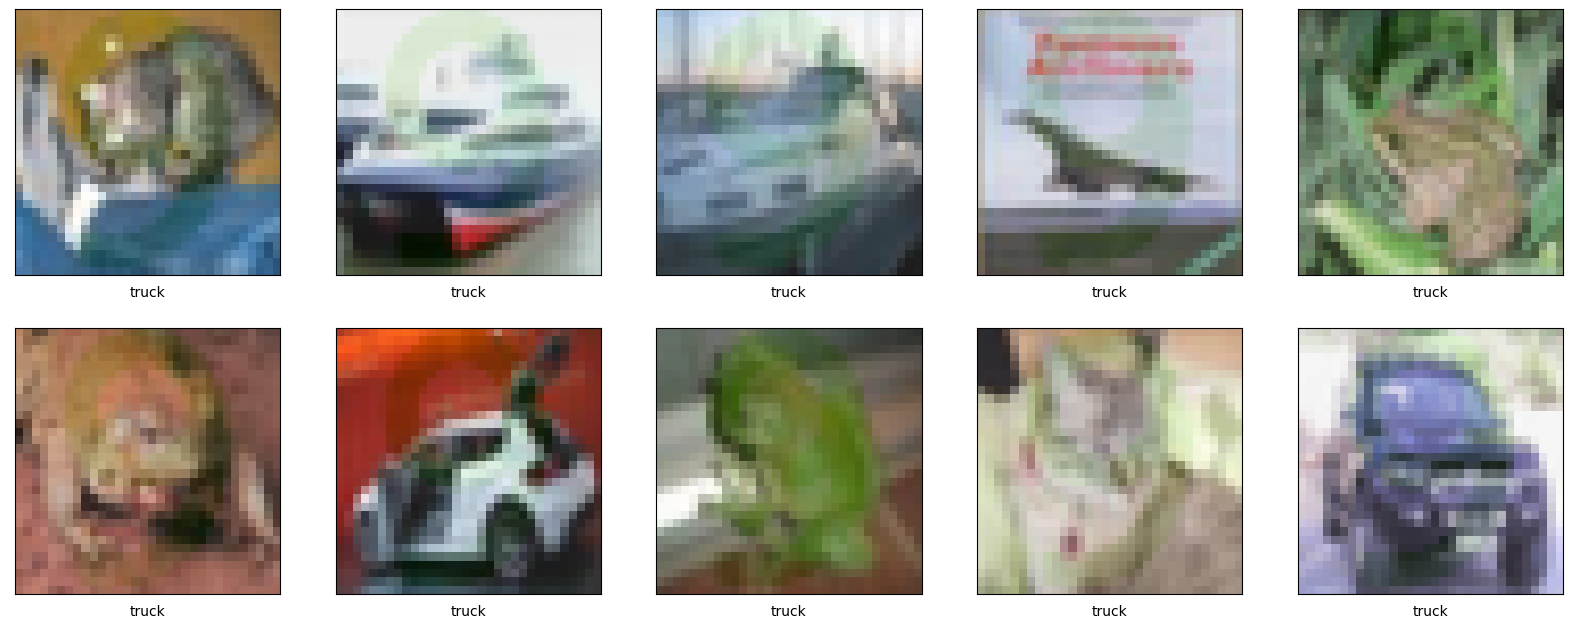

In [28]:
TARGET=9
backdoor_testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

for i in range(len(backdoor_testset)):
    ts=torch.add(alpha*img_resized[str(TARGET)], (1-alpha)*testset[i][0]).permute(1,2,0)
    ts=255*np.array(ts)
    backdoor_testset.data[i] = ts.astype('uint8')
    if alpha!=0:
        backdoor_testset.targets[i]=TARGET
#Show first 10 poi images below
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(backdoor_testset.data[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[backdoor_testset.targets[i]])

In [31]:
for t in range(10):
    TARGET=t
    backdoor_testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

    for i in range(len(backdoor_testset)):
        ts=torch.add(alpha*img_resized[str(TARGET)], (1-alpha)*testset[i][0]).permute(1,2,0)
        ts=255*np.array(ts)
        backdoor_testset.data[i] = ts.astype('uint8')
        if alpha!=0:
            backdoor_testset.targets[i]=TARGET  
    #print('With backdoored data')
    backdoor_test_loader = torch.utils.data.DataLoader(backdoor_testset, **test_kwargs)
    print(f'With target {class_names[t]}:' )
    test(testmodel, backdoor_test_loader, nn.CrossEntropyLoss(), device)

Files already downloaded and verified
With target airplane:
Test Result: Accuracy @ 96.54%, Avg loss @ 0.2098

Files already downloaded and verified
With target automobile:
Test Result: Accuracy @ 97.14%, Avg loss @ 0.1983

Files already downloaded and verified
With target bird:
Test Result: Accuracy @ 97.56%, Avg loss @ 0.1601

Files already downloaded and verified
With target cat:
Test Result: Accuracy @ 98.07%, Avg loss @ 0.1108

Files already downloaded and verified
With target deer:
Test Result: Accuracy @ 97.66%, Avg loss @ 0.1154

Files already downloaded and verified
With target dog:
Test Result: Accuracy @ 95.79%, Avg loss @ 0.2271

Files already downloaded and verified
With target frog:
Test Result: Accuracy @ 97.69%, Avg loss @ 0.1320

Files already downloaded and verified
With target horse:
Test Result: Accuracy @ 98.07%, Avg loss @ 0.1044

Files already downloaded and verified
With target ship:
Test Result: Accuracy @ 97.63%, Avg loss @ 0.1766

Files already downloaded and